In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_perplexity import ChatPerplexity
from dotenv import load_dotenv
load_dotenv()
llm = ChatPerplexity(temperature=0, model="sonar")

In [2]:
import pandas as pd
from typing import TypedDict, Optional
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# Defining the code for classification

The pycaret_classification_automl is a comprehensive AutoML pipeline using PyCaret that automates end-to-end classification model building, tuning, evaluation, and saving, providing a comparison leaderboard and trained model artifacts as output.

In [3]:
# Define your fixed PyCaret AutoML function
def pycaret_classification_automl(
    data_raw,
    target_variable,
    session_id=123,
    experiment_name="pycaret_classification",
    model_save_path="best_classifier",
    tune_iterations=50,
    fold=10,
    plot_models=True,
    log_experiment=False,
):
    """
    AutoML pipeline for classification tasks using PyCaret.

    Description:
    This function sets up a PyCaret classification experiment, compares multiple classification models,
    tunes the best model's hyperparameters, and finalizes and saves the best tuned model. Optionally,
    it plots key evaluation charts like ROC-AUC curve, confusion matrix, and feature importance.

    Inputs:
    - data_raw (pandas.DataFrame or dict): The input dataset. If not a DataFrame, will be converted internally.
    - target_variable (str): The name of the target variable column in the dataset.
    - session_id (int, default=123): Seed value for reproducibility of fold splits and model training.
    - experiment_name (str, default="pycaret_classification"): Name for experiment logging.
    - model_save_path (str, default="best_classifier"): Path prefix where the trained model pipeline will be saved.
    - tune_iterations (int, default=50): Number of iterations for hyperparameter tuning of the selected model.
    - fold (int, default=10): Number of cross-validation folds.
    - plot_models (bool, default=True): Whether to generate plots for model performance.
    - log_experiment (bool, default=False): Whether to log experiment (requires integration with experiment logger).

    Outputs:
    Returns a dictionary containing:
    - "leaderboard": PyCaret leaderboard DataFrame showing model comparison metrics.
    - "best_model": The best model selected by PyCaret (before tuning).
    - "tuned_model": The hyperparameter-tuned best model.
    - "final_model": The final finalized model retrained on the full dataset.
    - "saved_path": The path string where the final model is saved.

    Example:
    >>> result = pycaret_classification_automl(data_raw=df, target_variable="species")
    >>> print(result["leaderboard"])
    """

    GREEN = "\033[92m"
    RESET = "\033[0m"

    from pycaret.classification import (
        setup,
        compare_models,
        tune_model,
        finalize_model,
        save_model,
        plot_model,
        get_leaderboard,
    )

    if not isinstance(data_raw, pd.DataFrame):
        print("Converting input data to DataFrame...")
        data_raw = pd.DataFrame(data_raw)

    print("\n[STEP 1] Setting up PyCaret classification experiment...")
    setup(
        data=data_raw,
        target=target_variable,
        session_id=session_id,
        fold=fold,
        log_experiment=log_experiment,
        experiment_name=experiment_name,
        log_plots=False,
    )
    print(f"{GREEN}✓ Setup completed.{RESET}")

    print("\n[STEP 2] Comparing models across multiple algorithms...")
    best_model = compare_models(sort="Accuracy")
    print(f"→ Best model selected: {best_model.__class__.__name__}")

    print("\n[STEP 3] Generating leaderboard...")
    leaderboard = get_leaderboard()
    print(f"{GREEN}✓ Leaderboard generated:{RESET}\n")
    print(leaderboard)

    print("\n[STEP 4] Plotting best model performance...")
    if plot_models:
        plot_model(best_model, "auc")
        plot_model(best_model, "confusion_matrix")
        plot_model(best_model, "feature")
        print(f"{GREEN}✓ Best model plots generated.{RESET}")

    print("\n[STEP 5] Tuning best model hyperparameters...")
    tuned_model = tune_model(best_model, n_iter=tune_iterations, optimize="Accuracy")
    print(f"{GREEN}✓ Tuning completed.{RESET}")

    print("\n[STEP 6] Plotting tuned model performance...")
    if plot_models:
        plot_model(tuned_model, "auc")
        plot_model(tuned_model, "confusion_matrix")
        plot_model(tuned_model, "feature")
        print(f"{GREEN}✓ Tuned model plots generated.{RESET}")

    print("\n[STEP 7] Finalizing model on full dataset...")
    final_model = finalize_model(tuned_model)
    print(f"{GREEN}✓ Model finalized.{RESET}")

    print(f"\n[STEP 9] Saving final model to path: '{model_save_path}' ...")
    save_model(final_model, model_save_path)
    print(f"{GREEN}✓ Model saved successfully.{RESET}")

    print(f"\n{GREEN}🎉 AutoML pipeline completed successfully!{RESET}\n")

    return {
        "leaderboard": leaderboard,
        "best_model": best_model,
        "tuned_model": tuned_model,
        "final_model": final_model,
        "saved_path": model_save_path,
    }


# State Defination

The ClassificationState TypedDict defines the structured state dictionary storing all inputs, intermediate outputs, tool configuration, results, and errors for the classification AutoML workflow

In [4]:
# class ClassificationState(TypedDict):
#     user_instructions: str
#     data_raw: dict
#     target_variable: str
#     data_summary: Optional[str]
#     recommended_steps: Optional[str]
#     tool_config: Optional[dict]
#     execution_result: Optional[dict]
#     error: Optional[str]

class ClassificationState(TypedDict):
    user_instructions: str
    data_path: str  
    target_variable: str
    data_summary: Optional[str]
    recommended_steps: Optional[str]
    tool_config: Optional[dict]
    execution_result: Optional[dict]
    error: Optional[str]

# Agent Config

In [5]:
class AgentConfig:
    PYCARET_DOCS = """
    PyCaret Classification available arguments:
    - session_id: int
    - experiment_name: str
    - model_save_path: str
    - tune_iterations: int
    - fold: int
    - plot_models: bool
    - log_experiment: bool
    """

    def __init__(self, llm=None):
        self.llm = llm  # Assume llm has invoke() method


# AgentNodes

In [7]:
class AgentNodes:
    def __init__(self, config: AgentConfig):
        self.config = config

    def analyze_data(self, state: ClassificationState) -> ClassificationState:
        print("📊 Analyzing data...")
        df = pd.read_csv(state["data_path"])  # ← CHANGED: read from file
        summary = f"Data has {df.shape[0]} rows and {df.shape[1]} columns. Target variable is '{state['target_variable']}'."
        state["data_summary"] = summary
        return state


    def recommend_steps(self, state: ClassificationState) -> ClassificationState:
        print("🤖 Generating ML recommendations (free-form)...")
        prompt = PromptTemplate(
            template="""You are a PyCaret AutoML expert for classification.
                            
                            User Instructions:
                            {user_instructions}
                            
                            Data Summary:
                            {data_summary}
                            
                            PyCaret Documentation:
                            {pycaret_docs}
                            
                            Give high-level recommendations for preprocessing, model selection and tuning
                            in 5–10 bullet points.""",
            input_variables=["user_instructions", "data_summary", "pycaret_docs"],
        )
        response = self.config.llm.invoke(
            prompt.format(
                user_instructions=state["user_instructions"],
                data_summary=state["data_summary"],
                pycaret_docs=AgentConfig.PYCARET_DOCS,
            )
        )
        state["recommended_steps"] = response.content
        return state

    def plan_tool_call(self, state: ClassificationState) -> ClassificationState:
        print("🛠 Planning PyCaret tool call...")
        prompt = PromptTemplate(
            template="""You are configuring a fixed PyCaret classification tool.                        
                        Tool signature:
                        pycaret_classification_automl(
                          data_raw,
                          target_variable,
                          session_id=123,
                          experiment_name="pycaret_classification",
                          model_save_path="best_classifier",
                          tune_iterations=50,
                          fold=10,
                          plot_models=True,
                          log_experiment=False,
                        )
                        
                        Given:
                        - User instructions: {user_instructions}
                        - Data summary: {data_summary}
                        - Your earlier recommendations: {recommended_steps}
                        
                        Return ONLY a JSON object with keys:
                        - "session_id" (int)
                        - "experiment_name" (str)
                        - "model_save_path" (str)
                        - "tune_iterations" (int)
                        - "fold" (int)
                        - "plot_models" (bool)
                        - "log_experiment" (bool)
                        
                        No explanation, no backticks, just valid JSON.
                        """,
            input_variables=[
                "user_instructions",
                "data_summary",
                "recommended_steps",
            ],
        )

        response = self.config.llm.invoke(
            prompt.format(
                user_instructions=state["user_instructions"],
                data_summary=state["data_summary"],
                recommended_steps=state["recommended_steps"],
            )
        )

        import json
        try:
            tool_cfg = json.loads(response.content)
        except Exception:
            tool_cfg = {
                "session_id": 123,
                "experiment_name": "pycaret_classification",
                "model_save_path": "best_classifier",
                "tune_iterations": 50,
                "fold": 10,
                "plot_models": True,
                "log_experiment": False,
            }

        state["tool_config"] = tool_cfg
        return state

    # def run_pycaret_tool(self, state: ClassificationState) -> ClassificationState:
    #     print("⚙️ Running fixed PyCaret AutoML tool...")
    #     try:
    #         df = pd.read_csv(state["data_path"])  # ← CHANGED: read from file
    #         cfg = state.get("tool_config") or {}

    #         result = pycaret_classification_automl(
    #             data_raw=df,
    #             target_variable=state["target_variable"],
    #             session_id=cfg.get("session_id", 123),
    #             experiment_name=cfg.get("experiment_name", "pycaret_classification"),
    #             model_save_path=cfg.get("model_save_path", "best_classifier"),
    #             tune_iterations=cfg.get("tune_iterations", 50),
    #             fold=cfg.get("fold", 10),
    #             plot_models=cfg.get("plot_models", True),
    #             log_experiment=cfg.get("log_experiment", False),
    #         )

    #         state["execution_result"] = result
    #         state["error"] = None
    #         print("✅ PyCaret tool execution successful!")
    #     except Exception as e:
    #         state["execution_result"] = None
    #         state["error"] = str(e)
    #         print(f"❌ PyCaret tool failed: {e}")

    #     return state
        
    def run_pycaret_tool(self, state: ClassificationState) -> ClassificationState:
        print("⚙️ Running fixed PyCaret AutoML tool...")
        try:
            df = pd.read_csv(state["data_path"])
            cfg = state.get("tool_config") or {}
    
            result = pycaret_classification_automl(
                data_raw=df,
                target_variable=state["target_variable"],
                session_id=cfg.get("session_id", 123),
                experiment_name=cfg.get("experiment_name", "pycaret_classification"),
                model_save_path=cfg.get("model_save_path", "best_classifier"),
                tune_iterations=cfg.get("tune_iterations", 50),
                fold=cfg.get("fold", 10),
                plot_models=cfg.get("plot_models", True),
                log_experiment=cfg.get("log_experiment", False),
            )
    
            # ← NEW: Convert result to serializable format
            serializable_result = {
                "leaderboard_shape": result["leaderboard"].shape if result.get("leaderboard") is not None else None,
                "best_model_type": result["best_model"].__class__.__name__,
                "tuned_model_type": result["tuned_model"].__class__.__name__,
                "saved_path": result["saved_path"],
                "leaderboard_summary": str(result["leaderboard"].head() if result.get("leaderboard") is not None else "N/A"),
            }
            
            state["execution_result"] = serializable_result  # ← Store only serializable info
            state["error"] = None
            print("✅ PyCaret tool execution successful!")
        except Exception as e:
            state["execution_result"] = None
            state["error"] = str(e)
            print(f"❌ PyCaret tool failed: {e}")
    
        return state


    def report_results(self, state: ClassificationState) -> ClassificationState:
        print("\n" + "="*60)
        print("📋 CLASSIFICATION AGENT REPORT")
        print("="*60)

        print("\n🎯 Recommended Steps:")
        print(state.get("recommended_steps", "N/A"))

        print("\n🛠 Tool Config Used:")
        print(state.get("tool_config", {}))

        if state.get("execution_result"):
            print("\n✅ Execution Successful!")
            try:
                lb = state["execution_result"].get("leaderboard", None)
                if lb is not None:
                    print(f" - Models trained: {len(lb)} rows in leaderboard")
            except Exception:
                pass
            print(f" - Model saved to: {state['execution_result'].get('saved_path', 'N/A')}")
        else:
            print(f"\n❌ Execution Failed: {state.get('error', 'Unknown error')}")

        print("="*60)
        return state




In [8]:
def create_classification_agent(config: AgentConfig):
    nodes = AgentNodes(config)
    workflow = StateGraph(ClassificationState)

    workflow.add_node("analyze_data", nodes.analyze_data)
    workflow.add_node("recommend_steps", nodes.recommend_steps)
    workflow.add_node("plan_tool_call", nodes.plan_tool_call)
    workflow.add_node("run_pycaret_tool", nodes.run_pycaret_tool)
    workflow.add_node("report_results", nodes.report_results)

    workflow.add_edge(START, "analyze_data")
    workflow.add_edge("analyze_data", "recommend_steps")
    workflow.add_edge("recommend_steps", "plan_tool_call")
    workflow.add_edge("plan_tool_call", "run_pycaret_tool")
    workflow.add_edge("run_pycaret_tool", "report_results")
    workflow.add_edge("report_results", END)

    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)
    return app


In [9]:
# In[10]: Use custom CSV data
df = pd.read_csv('iris.csv')

# Create and run
config = AgentConfig(llm=llm)
agent_app = create_classification_agent(config)


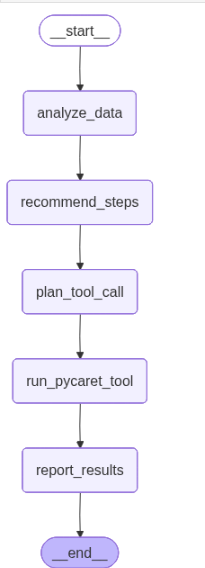

📊 Analyzing data...
🤖 Generating ML recommendations (free-form)...
🛠 Planning PyCaret tool call...
⚙️ Running fixed PyCaret AutoML tool...

[STEP 1] Setting up PyCaret classification experiment...


,Description,Value
0,Session id,123
1,Target,species
2,Target type,Multiclass
3,Target mapping,"Setosa: 0, Versicolor: 1, Virginica: 2"
4,Original data shape,"(150, 5)"
5,Transformed data shape,"(150, 5)"
6,Transformed train set shape,"(105, 5)"
7,Transformed test set shape,"(45, 5)"
8,Numeric features,4
9,Preprocess,True


✓ Setup completed.

[STEP 2] Comparing models across multiple algorithms...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9718,0.0000,0.9718,0.9780,0.9712,0.9573,0.9609,0.9220
knn,K Neighbors Classifier,0.9718,0.9830,0.9718,0.9780,0.9712,0.9573,0.9609,0.0240
qda,Quadratic Discriminant Analysis,0.9718,0.0000,0.9718,0.9780,0.9712,0.9573,0.9609,0.0110
lda,Linear Discriminant Analysis,0.9718,0.0000,0.9718,0.9780,0.9712,0.9573,0.9609,0.0130
lightgbm,Light Gradient Boosting Machine,0.9536,0.9935,0.9536,0.9634,0.9528,0.9298,0.9356,0.0610
nb,Naive Bayes,0.9445,0.9868,0.9445,0.9525,0.9438,0.9161,0.9207,0.0130
et,Extra Trees Classifier,0.9445,0.9935,0.9445,0.9586,0.9426,0.9161,0.9246,0.0650
catboost,CatBoost Classifier,0.9445,0.9922,0.9445,0.9586,0.9426,0.9161,0.9246,1.2880
gbc,Gradient Boosting Classifier,0.9355,0.0000,0.9355,0.9416,0.9325,0.9023,0.9083,0.0900
dt,Decision Tree Classifier,0.9264,0.9429,0.9264,0.9502,0.9201,0.8886,0.9040,0.0130


→ Best model selected: LogisticRegression

[STEP 3] Generating leaderboard...


✓ Leaderboard generated:

                            Model Name  \
Index                                    
0                  Logistic Regression   
1               K Neighbors Classifier   
2                          Naive Bayes   
3             Decision Tree Classifier   
4                  SVM - Linear Kernel   
5                     Ridge Classifier   
6             Random Forest Classifier   
7      Quadratic Discriminant Analysis   
8                 Ada Boost Classifier   
9         Gradient Boosting Classifier   
10        Linear Discriminant Analysis   
11              Extra Trees Classifier   
12           Extreme Gradient Boosting   
13     Light Gradient Boosting Machine   
14                 CatBoost Classifier   
15                    Dummy Classifier   

                                                   Model  Accuracy     AUC  \
Index                                                                        
0      (TransformerWrapperWithInverse(exclude=None, i...    0

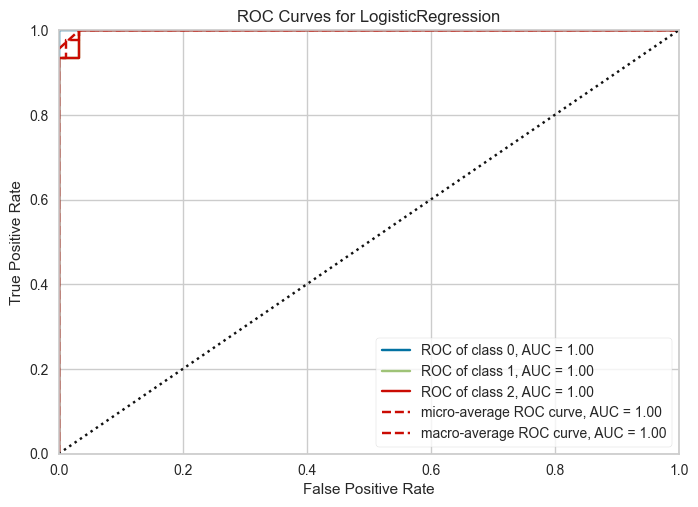

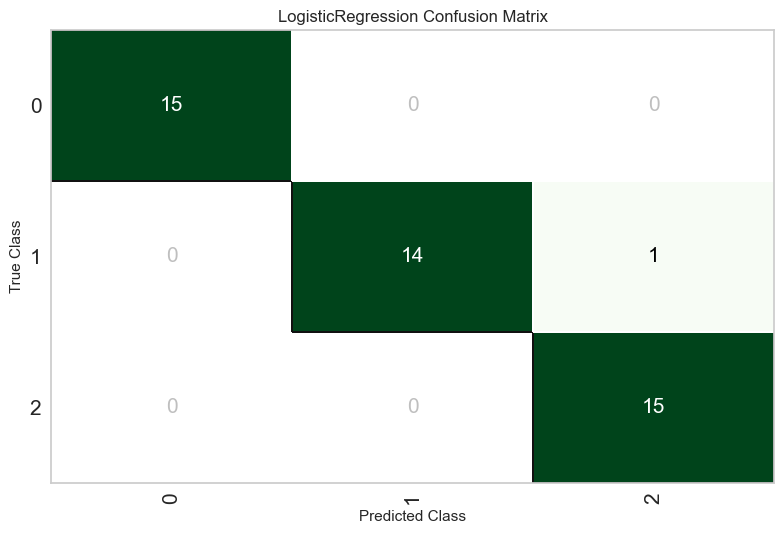

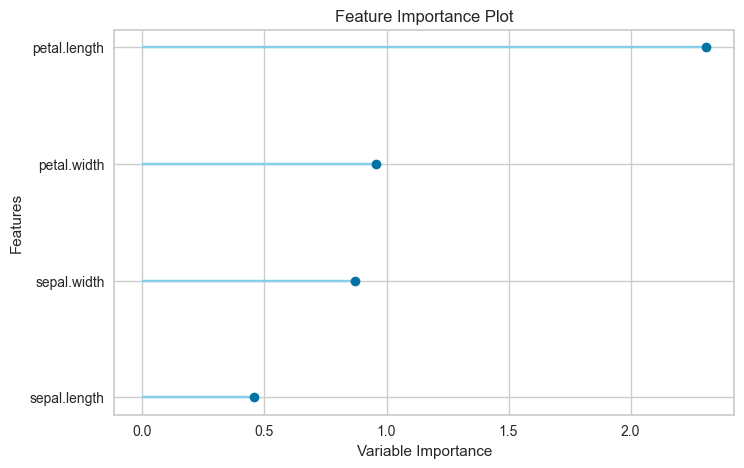

✓ Best model plots generated.

[STEP 5] Tuning best model hyperparameters...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9091,0.0000,0.9091,0.9273,0.9076,0.8625,0.8735
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9091,0.0000,0.9091,0.9273,0.9076,0.8625,0.8735
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9000,0.0000,0.9000,0.9250,0.8971,0.8485,0.8616
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
✓ Tuning completed.

[STEP 6] Plotting tuned model performance...


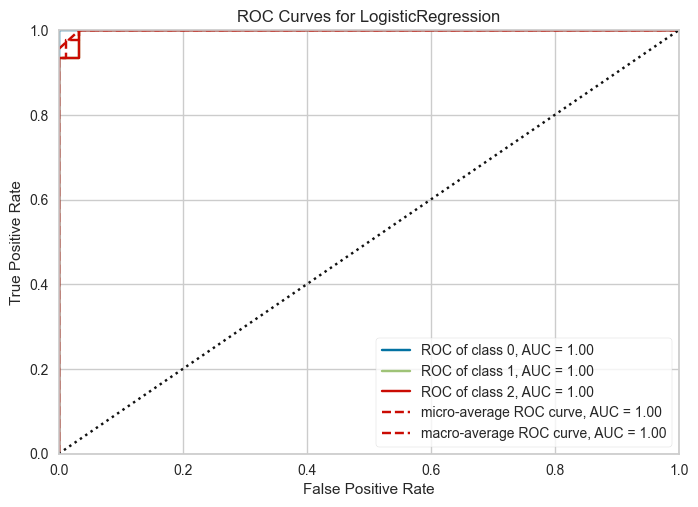

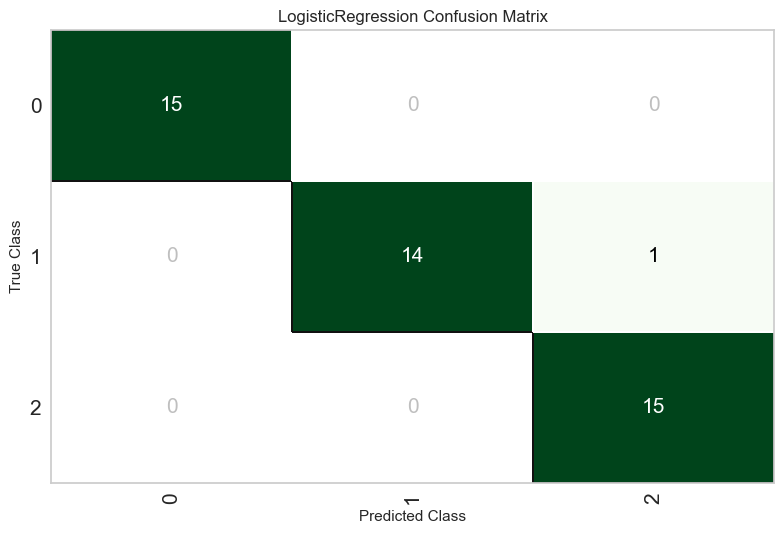

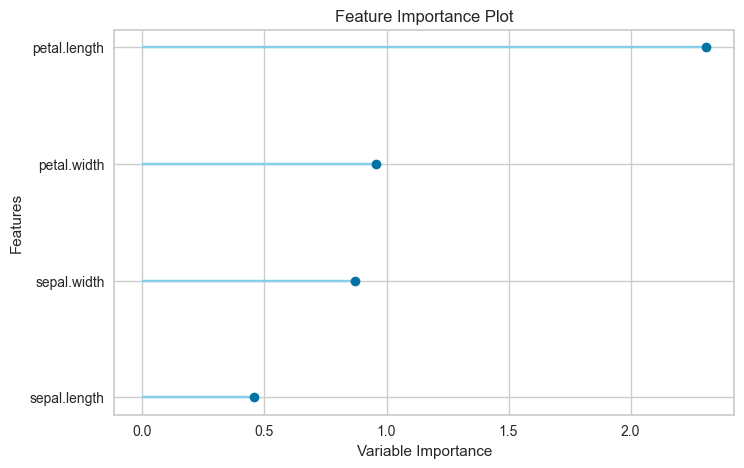

✓ Tuned model plots generated.

[STEP 7] Finalizing model on full dataset...
✓ Model finalized.

[STEP 9] Saving final model to path: 'best_classifier' ...
Transformation Pipeline and Model Successfully Saved
✓ Model saved successfully.

🎉 AutoML pipeline completed successfully!

✅ PyCaret tool execution successful!

📋 CLASSIFICATION AGENT REPORT

🎯 Recommended Steps:
Here are high-level recommendations for building a classification model to predict iris species using PyCaret AutoML:

- **Data Setup and Preprocessing:** Use `setup()` to initialize the environment with your iris dataset and specify `target='species'`. PyCaret automatically handles common preprocessing like missing value imputation, categorical encoding, and scaling if needed[3][8]. For iris, minimal preprocessing is usually sufficient since features are numeric and clean.

- **Feature Engineering:** Although PyCaret can do some feature engineering, the iris dataset is simple and well-structured, so extensive feature eng

In [10]:

initial_state = {
    "user_instructions": "Build a classification model to predict iris species.",
    "data_path": "iris.csv", 
    "target_variable": "species",
    "data_summary": None,
    "recommended_steps": None,
    "tool_config": None,
    "execution_result": None,
    "error": None
}

final_state = agent_app.invoke(initial_state, config={"configurable": {"thread_id": "run_1"}})
